In [42]:
from chem_ocean.ocean_data import dataFetcher, water_column
from chem_ocean.ocean_plt import rawPlotter

In [43]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

import seaborn as sns
%matplotlib inline

import pandas as pd
import numpy as np

axis_sz= 14
tick_sz= 14

In [44]:
# @todo: must fix the data import to accomodate multiple tracers
    # update: does using cluster_d, but not fully masked 
# @todo: add function for loading data into a dataframe (for seaborn)
    # update: fix cluster_d to have all columns reflect dropna masking will resolve this

In [45]:
# @todo: break these functions out into three separate functions
def ox_po4_convert(dataset, **kwargs):
    if max(dataset.cluster_d['oxygen'])<300:
        ox_convert = lambda x: x*44.661
        dataset.cluster_d['oxygen'] = ox_convert(dataset.cluster_d['oxygen'])

    OP = {'SAtl':182, 'NAtl':173}
    po4_convert = lambda x,y: x + y/175
    if 'corrected_OP' in kwargs:
        po4_star_c = []
        po4_convert_corr = lambda x,y,z: x + y/OP[z]
        for ik in range(len(dataset.cluster_d['latitude'])):
            if dataset.cluster_d['labels'][ik] in OP:
                po4_star_c.append(po4_convert_corr(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik], dataset.cluster_d['labels'][ik]))
            else:
                po4_star_c.append(po4_convert(dataset.cluster_d['phosphate'][ik], dataset.cluster_d['oxygen'][ik]))
        dataset.cluster_d['po4_star_c'] = np.asarray(po4_star_c, dtype=float)
    dataset.cluster_d['po4_star'] = po4_convert(dataset.cluster_d['phosphate'], dataset.cluster_d['oxygen'])
    return dataset

def label_lat_ranges(dataset):
    lat_range_d = {(90,-10):'NAtl', (-10, -50):'SAtl', (-50, -70):'SO_CDW', (-70,-90):'SO_shelf'}
    labels = []
    
    for lat in dataset.cluster_d['latitude']:
        for key in lat_range_d:
            if lat<=key[0] and lat>key[1]:
                labels.append(lat_range_d[key])
    dataset.cluster_d['labels']= labels
    
    return dataset

## Background & Problem

### Observed Tracers
As processes occur in the ocean, the concentration of chemical constituents change. For example, evaporation results in increased salinity, and cell building by organisms takes up dissolved phosphate from the surrounding water, driving down the phosphate concentration.  Salinity, and phosphate, in addition to nitrate, oxygen, and temperature (though a physical parameter of the ocean rather than a chemical), among many others, are referred to as "tracers" because when plotted out, they help oceanographers "trace" the paths of water and the processes occurring in the ocean. When a tracer concentration is  determined at the ocean surface at water formation and is distributed strictly by ocean circulation and mixing (viz. is unaffected by any additional biogeochemical processes), the tracers is considered “conservative.” Salinity, as well as certain CFCs present in the atmosphere that dissolve in surface water, are examples of conservative tracers. 

### PO<sub>4</sub>\*

The concentration of phosphate in the deep ocean reflects a combination of the amount of phosphate present in the water at the time of water formation, and the amount contributed by regenerated organic matter (phytoplankton that have died, sunk to some depth, and dissolved into constituent molecules).  In 1998, Broecker et al. published a paper suggesting the use of a calculated tracer, PO<sub>4</sub>\*, that reflected the concentration of preformed nutrients (the concentration present in the water at the time of water formation).  Their argument was that by correcting for the non-conservative contribution to PO<sub>4</sub>, PO<sub>4</sub>\* would act as a conservative tracer and therefore could be used to trace the relative contributions of different watermasses at a given location.

The formula they put forth was relatively simple:  
PO<sub>4</sub>\* =PO<sub>4</sub> + O<sub>2</sub>/175 -1.95  
(though the constant is a scaling factor and doesn't affect study of the relative differences in PO<sub>4</sub>\*)

where 175 is the global average moles of oxygen per molecule PO<sub>4</sub> needed to respire marine organic matter.  

Indeed, work in the late 1960s by Redfield et al., gave rise to a general notion that nutrients are taken up by phytoplankton in a suprisingly consistent ratio of carbon:nitrate:phosphate and generalized to the idea that a similarly consistent amount of oxygen would be consumed in the respiration of this organic matter post mortum....hence the 175 generalization.  While the so called "Redfield ratio" persists as a rule of thumb, there is a growing number of studies that suggest that the composition of phytoplankton populations vary by region (and therefore so too does the number moles of O<sub>2</sub> needed to respire said organic matter, viz. the O<sub>2</sub>/PO<sub>4</sub>).   

### Problem

PO$_4$\* is conceptually pleasing, but a recent paper by Rae and Broecker (2018) attempted to calculate the ratio of Southern Ocean to North Atlantic Deep Water in the Pacific based on PO$_4$\* and came up short when they compared their calculations to the numbers necessary to satisfy the salinity budget of the deep Pacific.  

## Hypothesis
I hypothesize that specifying the O<sub>2</sub>/PO$_4$ by region may improve the watermass fraction estimates generated using PO$_4$\* and bring them more in line with those calculated based on salinity. 

## Plan
#### World Ocean Atlas 2013
The World Ocean Atlas 2013 is an ocean data product produced by the Ocean Climate Laboratory and the National Oceanographic Data Center.  WOA fields include temperature, salinity, phosphate, nitrate, oxygen, silicic acid, among others and are reported at 1 degree resolution at 102 standard depth levels from surface to the abyssal floor (5500m). 

1.) Explore the relationship between nutrients in the Atlantic Ocean (seaborn pairplot)  
2.) Look into conservative nature of tracers (histograms)  
3.) Look into PO4*  (plot against PO4, salinity)
4.) Calculate whether the fractions for salinity are different from those for PO4*  
5.) Calculate whether the regional correction produces a difference  
6.) Analyze correction effect for lurking variables

In [46]:
tracers_psql = ['phosphate', 'oxygen', 'nitrate', 'salinity']
tracer_string = ','.join(tracers_psql)

In [47]:
dataset_Atl = dataFetcher()
dataset_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < 0 and longitude >-70 and latitude> -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_Atl= ox_po4_convert(label_lat_ranges(dataset_Atl), corrected_OP= True)
df_Atl = pd.DataFrame(dataset_Atl.cluster_d)


In [48]:
dataset_SO = dataFetcher()
dataset_SO.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_SO= ox_po4_convert(label_lat_ranges(dataset_SO), corrected_OP= True)
df_SO = pd.DataFrame(dataset_SO.cluster_d)


In [54]:
def concat(dataset1, dataset2):
    for key in dataset1.cluster_d.keys():
        dataset1.cluster_d[key] = np.concatenate((dataset1.cluster_d[key], dataset2.cluster_d[key]))
    dataset1._x = dataset1.cluster_d['longitude']
    dataset1._y = dataset1.cluster_d['latitude']     
    dataset1._d = dataset1.cluster_d['depth']                                            
    return dataset1

In [61]:
# key: ([min_lon, max_lon], [min_lat, max_lat])

ocean_parts = {'NNAtl':([-70,10],[60,90]),
               'NAtl': ([-70, -10],[60,0]),
               'SAtl': ([-70,20],[-50,0]),
               'Ind': ([20,90],[-50,10]),
               'Aus': ([90,150],[-50, -10]),
               'NPac_E': ([-180,-100],[0, 50]),
               'NPac_W': ([140, 180],[0, 50]),
               'SPac_E': ([-180, -70],[-50, 0]),
               'SPac_W': ([150, 180],[-50, 0])
                    }

In [63]:
dataset_globe = dataFetcher()
dataset_globe.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <= -70 and depth >=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
for key in ocean_parts.keys():
    ([min_lon, max_lon], [min_lat, max_lat]) = ocean_parts[key]
    dataset_new = dataFetcher()
    dataset_new.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE longitude < {} and longitude >{} and latitude <{} and latitude> {} and depth >=3000'.format(tracer_string, max_lon, min_lon, max_lat, min_lat),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
    dataset_globe = concat(dataset_globe, dataset_new)


In [64]:
dataset_globe.cluster_d['labels'] = ['global' for ik in range(len(dataset_globe.cluster_d['latitude']))]
dataset_globe= ox_po4_convert(dataset_globe, corrected_OP= True)
df_globe = pd.DataFrame(dataset_globe.cluster_d)

In [12]:
# Global Ocean
dataset_globe = dataFetcher()

dataset_globe.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE depth >=3000 and salinity<38 and salinity>34.5'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_globe.cluster_d['labels'] = ['global' for ik in range(len(dataset_globe.cluster_d['latitude']))]
dataset_globe= ox_po4_convert(dataset_globe, corrected_OP= True)
df_globe = pd.DataFrame(dataset_globe.cluster_d)

In [65]:
df_all = pd.concat([df_Atl,df_SO, df_globe])

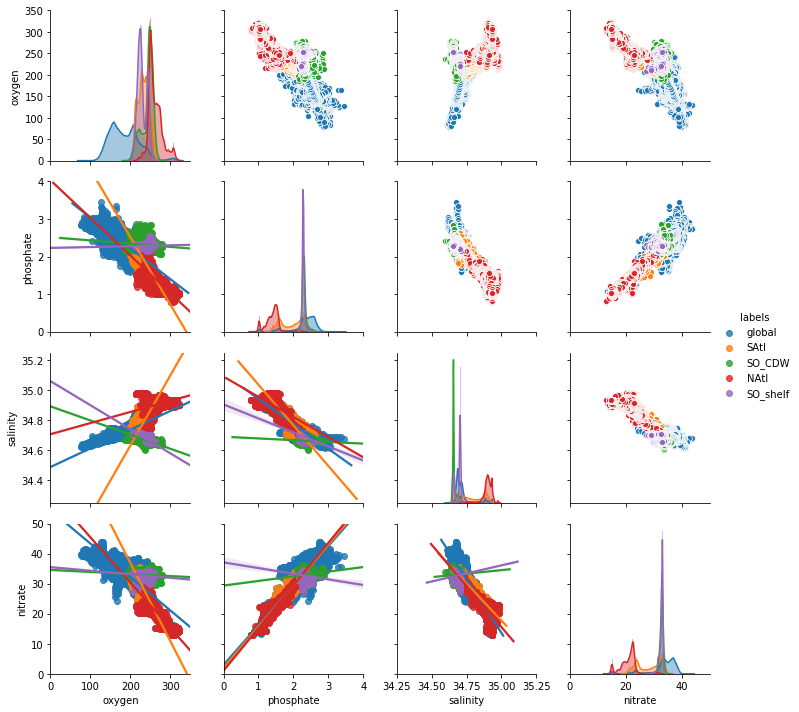

In [67]:
g = sns.PairGrid(df_all[['oxygen', 'phosphate', 'salinity', 'nitrate', 'labels']], diag_sharey=False, hue = 'labels', hue_order = ['global', 'SAtl', 'SO_CDW','NAtl','SO_shelf' ])
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)

g.set(alpha=0.1)

g.axes[0,0].set_xlim(0,350)
g.axes[0,0].set_ylim(0,350)
g.axes[0,1].set_xlim(0,4)
g.axes[1,0].set_ylim(0,4)
g.axes[0,2].set_xlim(34.25,35.25)
g.axes[2,0].set_ylim(34.25,35.25)
g.axes[0,3].set_xlim(0,50)
g.axes[3,0].set_ylim(0,50)

g.add_legend()


The scatter plots above suggest that PO<sub>4</sub> has the tightest relationship to salinity.  Unlike nitrate and oxygen, [PO<sub>4</sub>] is not affected by additional processes besides uptake and release by organisms.  (Oxygen and nitrate are both oxidation agents in the respiration of organic matter, and the equilibration with the atmosphere also affects the concentration of oxygen in the surface ocean.) 

In [68]:
# High Latitude Atlantic
dataset_high_lat_Atl = dataFetcher()
dataset_high_lat_Atl.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE (longitude < 0 and longitude >-70) and (latitude >50 or latitude <-45) and depth >=2500'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers_psql, tracers_psql, 'longitude', 'latitude')
dataset_high_lat_Atl= ox_po4_convert(dataset_high_lat_Atl)


High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)


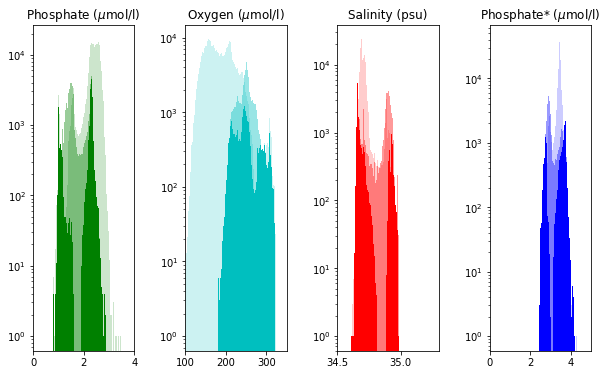

In [69]:
print('High latitude Atlantic basin below 3000 m (dark), Atlantic below 3000m (medium), global ocean below 3000 m (light)')
tracers = {'phosphate': ['Phosphate ($\mu$mol/l)', [0, 4], 'g'],
          'oxygen': ['Oxygen ($\mu$mol/l)', [100, 350], 'c'],
          'salinity': ['Salinity (psu)', [34.5, 35.3], 'r'],
          'po4_star': ['Phosphate* ($\mu$mol/l)', [0, 5], 'b']}

fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(1,len(tracers), width_ratios=np.ones(len(tracers)), wspace=0.5, hspace = 0.4) 
ax_out = []

for ik, tracer in enumerate(tracers):
    ax_out.append(fig.add_subplot(gs[ik]))
    n, bins, patches = ax_out[ik].hist(dataset_globe.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .2)
    n, bins, patches = ax_out[ik].hist(dataset_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = .4)
    n, bins, patches = ax_out[ik].hist(dataset_high_lat_Atl.cluster_d[tracer], 100, color = tracers[tracer][2], alpha = 1)
    ax_out[ik].set_xlim(tracers[tracer][1])
    ax_out[ik].set_title(tracers[tracer][0])
    plt.yscale('log', nonposy='clip')

The above histograms provide evidence that, while the ranges of PO<sub>4</sub> and oxygen extend beyond the values of the high latiude Atlantic and therefore would not make suitable tracers for calculating the relative contributions of North Atlantic and Southern Ocean water at a given point, PO<sub>4</sub>\* and salinity do a fairly good job bounding their respective global distributions. 

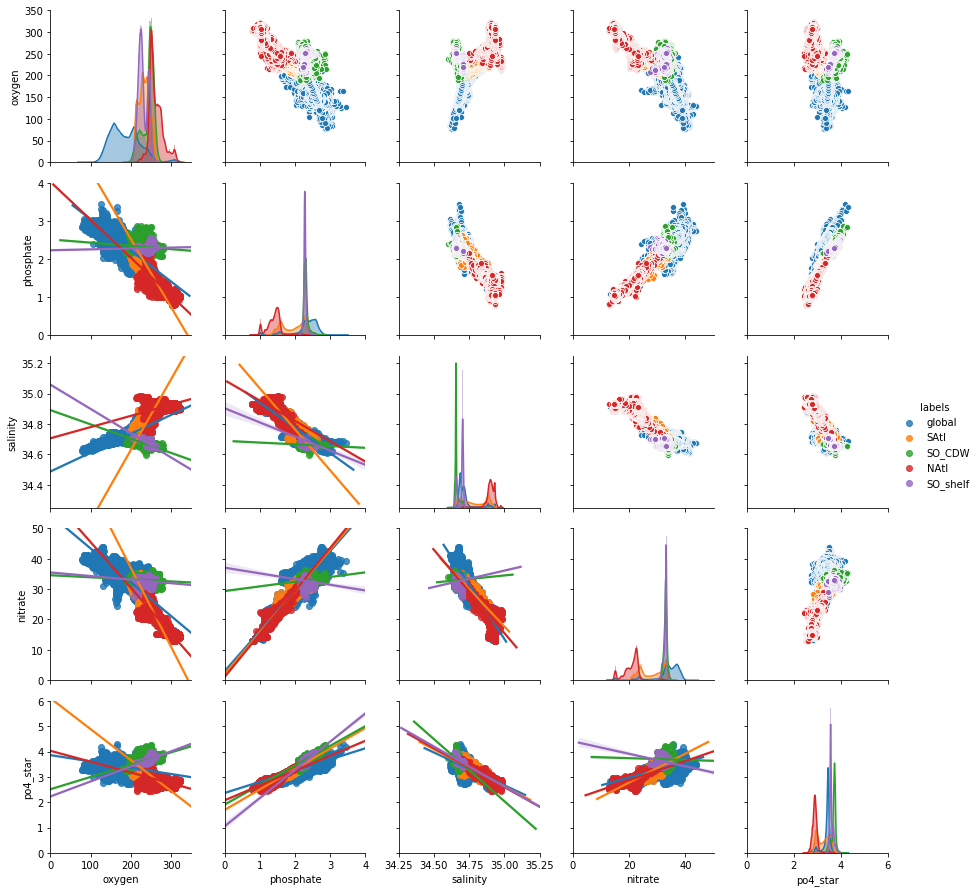

In [71]:
g = sns.PairGrid(df_all[['oxygen', 'phosphate', 'salinity', 'nitrate','po4_star', 'labels']], diag_sharey=False, hue = 'labels', hue_order = ['global', 'SAtl', 'SO_CDW','NAtl','SO_shelf' ])
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)

g.set(alpha=0.1)

g.axes[0,0].set_xlim(0,350)
g.axes[0,0].set_ylim(0,350)
g.axes[0,1].set_xlim(0,4)
g.axes[1,0].set_ylim(0,4)
g.axes[0,2].set_xlim(34.25,35.25)
g.axes[2,0].set_ylim(34.25,35.25)
g.axes[0,3].set_xlim(0,50)
g.axes[3,0].set_ylim(0,50)
g.axes[0,4].set_xlim(0,6)
g.axes[4,0].set_ylim(0,6)

g.add_legend()

Looking at the pairplot again (this time with PO<sub>4</sub>\* added), we can see that phosphate better bounds the global ocean than PO<sub>4</sub>.  Additionally, looking at the regression lines in the phosphate-nitrate plot, the similarity of the slopes for the Atlantic and global ocean lend credibility to the notion that the composition of phytoplancton is relatively consistent.  

With PO<sub>4</sub>\* justified as a tracer, let's consider how effective it is for calculating watermass fraction.  Borrowing code from the previous capstone exercise, I propose to calculate watermass fraction based on both salnity and PO<sub>4</sub>\* and compare them with a paired t-test.  

Given recent studies suggest that phytoplankton differ in composition regionally, and therefore differ in the amount of oxygen consumed in the break down of dead organic matter, I also propose to use these regional corrections to calculate a "corrected PO<sub>4</sub>\*" and compare the efficacy to that of uncorrected PO<sub>4</sub>\*. 

In [10]:
def get_mixing_ratios(n_char, s_char, water_col):
    ax = water_col._ax_avgd
        
    ik = 0
    colors = [('r', 'b'), ('b', 'y'), ('y', 'm'), ('m', 'g'), ('g', 'c'),('c','k')]
    color = []
    depth = ax[0]
    
    mixing_ratios = [np.zeros(2) for ik in range(len(ax))]
    for ik in range(len(ax)):
        mixing_ratios[ik][0] = max(min((water_col._feat_data_avgd[ik]-n_char)/(s_char-n_char), 1), 0)
        mixing_ratios[ik][1] = 1-mixing_ratios[ik][0]
        if mixing_ratios[ik][0] >= .5:
            color.append(colors[0][0])
        else:
            color.append(colors[0][1])
        ik+=1

    water_col.mixing_labels = color
    water_col.mixing_ratios = mixing_ratios
    water_col.n_char = n_char
    water_col.s_char = s_char

In [74]:
line_lon = -30
min_lat, max_lat = -80, 80

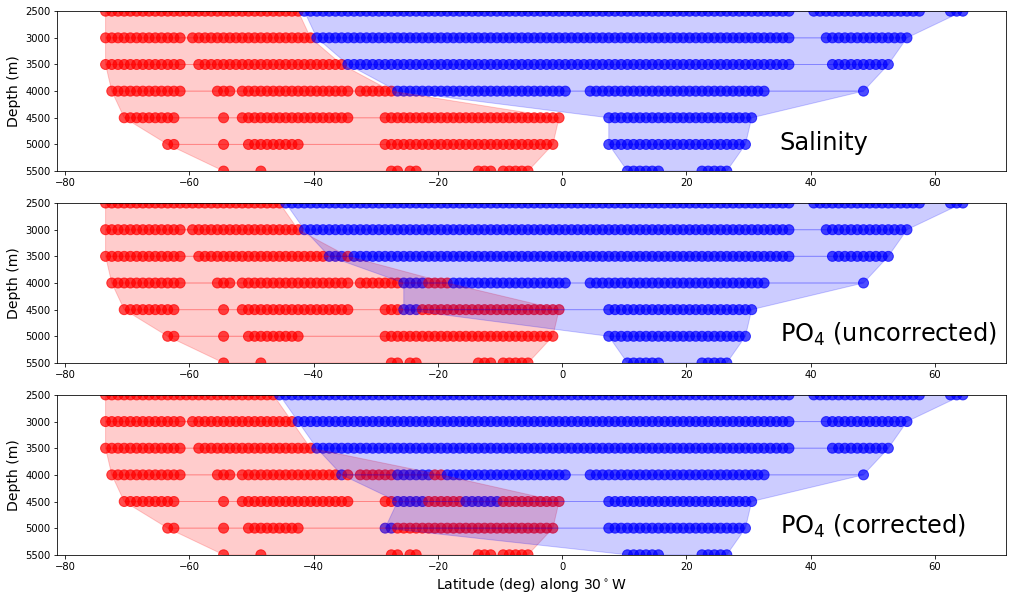

In [76]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(17, 10), facecolor='w')

tracers = ['salinity', 'phosphate', 'oxygen']
datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_traj = {}
df_mixing_ratios = pd.DataFrame({'lat':[], 'depth':[], 'mixing_fraction':[], 'tracer': []})

tracers = ['salinity', 'po4_star', 'po4_star_c']
#add data into dataframe join on latitude
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        get_mixing_ratios(Atl.n_char, Atl.s_char, Atl)
        d_traj[dpth] = Atl
        ax[im].scatter(Atl._ax_avgd, [dpth for ik in range(len(Atl._feat_data_avgd))], c = Atl.mixing_labels, alpha = .7, s=100)
        ax[im].set_ylim([6000,2000])
        df_new = pd.DataFrame({'lat':Atl._ax_avgd, 
                               'depth':[dpth for ik in range(len(Atl._feat_data_avgd))], 
                               'tracer' : [trcr for ik in range(len(Atl._feat_data_avgd))],
                               'mixing_fraction': [Atl.mixing_ratios[ik][0] for ik in range(len(Atl.mixing_ratios))]})
        df_mixing_ratios = pd.concat([df_mixing_ratios, df_new])
        # create lists of latitudes where there are red points and blue points
        x_int_r = []
        x_int_b = []
        for ip in range(len(Atl._feat_data_avgd)):
            if Atl.mixing_labels[ip] == 'r':
                x_int_r.append(Atl._ax_avgd[ip])
            else:
                x_int_b.append(Atl._ax_avgd[ip])

        # create lists of bounding points for each depth
        r.append([dpth, x_int_r[0], x_int_r[-1]])
        b.append([dpth, x_int_b[0], x_int_b[-1]])

    ### fill code
    r_pairs = [[r[n-1], r[n]] for n in range(1,len(r))]
    b_pairs = [[b[n-1], b[n]] for n in range(1,len(b))]

    pair_sets = {'r':[r_pairs, []], 'b':[b_pairs,[]]}

    for color in pair_sets.keys():
        for pair in pair_sets[color][0]:
            ul = [pair[0][1], pair[0][0]]
            ur = [pair[0][2], pair[0][0]]
            ll = [pair[1][1], pair[1][0]]
            lr = [pair[1][2], pair[1][0]]

            xs = [ik[0] for ik in [ll, ul, ur, lr]]
            ys = [ik[1] for ik in [ll, ul, ur, lr]]

            pair_sets[color][1].append([xs, ys])

        for d in pair_sets[color][1]:
            ax[im].fill(d[0],d[1], c=color, alpha=.2)

    ax[im].set_ylim([5500, 2500])

    ax[im].set_ylabel('Depth (m)', fontsize=axis_sz)
    ax[im].set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-line_lon), fontsize=axis_sz)

    # set tick parameters
    xtickNames = ax[im].get_xticklabels()
    ytickNames = ax[im].get_yticklabels()

    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4) 
    
    depth_traj[trcr] = d_traj

ax[0].xaxis.label.set_visible(False)
ax[1].xaxis.label.set_visible(False)

ax[0].text(35, 5100, 'Salinity', color='k', size=24)
ax[1].text(35, 5100, 'PO$_4$ (uncorrected)', color='k', size=24)
ax[2].text(35, 5100, 'PO$_4$ (corrected)', color='k', size=24)

# name1 = 'two_endmember_Atlantic'
# path = 'raw_demo_plots/connectedness/'
# plt.savefig(path+name1+'.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.2,
#         frameon=None)



In [88]:
df_mixing_ratios[['depth', 'tracer', 'mixing_fraction']].groupby(['depth', 'tracer']).describe()

mixing_fraction                                     \
                            count      mean       std  min       25%   
depth  tracer                                                          
2500.0 po4_star             132.0  0.326210  0.298826  0.0  0.163211   
       po4_star_c           132.0  0.309121  0.302393  0.0  0.109157   
       salinity             132.0  0.334853  0.333338 -0.0  0.123426   
3000.0 po4_star             124.0  0.356257  0.306542  0.0  0.180746   
       po4_star_c           124.0  0.337968  0.310389  0.0  0.135672   
       salinity             124.0  0.335355  0.356817 -0.0  0.090483   
3500.0 po4_star             119.0  0.392713  0.309514  0.0  0.195084   
       po4_star_c           119.0  0.374235  0.310230  0.0  0.154455   
       salinity             119.0  0.377293  0.357489 -0.0  0.118763   
4000.0 po4_star              97.0  0.541427  0.224567  0.0  0.366252   
       po4_star_c            97.0  0.526487  0.220251  0.0  0.370369   
       salinity              97.0  0.458676  0.362416 -0.0  0.080504   
4500.0 po4_star              81.0  0.508926  0.328323  0.0  0.082837   
       po4_star_c            81.0  0.480704  0.316281  0.0  0.084404   
       salinity              81.0  0.544627  0.366717 -0.0  0.039223   
5000.0 po4_star              63.0  0.490448  0.309338  0.0  0.140643   
       po4_star_c            63.0  0.466308  0.292220  0.0  0.143599   
       salinity              63.0  0.516974  0.381694 -0.0  0.041945   
5500.0 po4_star              25.0  0.458352  0.303754  0.0  0.158324   
       po4_star_c            25.0  0.443200  0.290190  0.0  0.161714   
       salinity              25.0  0.496854  0.422623 -0.0  0.043485   

                                            
                        50%       75%  max  
depth  tracer                               
2500.0 po4_star    0.207800  0.326659  1.0  
       po4_star_c  0.190507  0.271135  1.0  
       salinity    0.167092  0.477621  1.0  
3000.0 po4_star    0.215789  0.492011  1.0  
       po4_star_c  0.210975  0.439881  1.0  
       salinity    0.140832  0.600956  1.0  
3500.0 po4_star    0.233405  0.621330  1.0  
       po4_star_c  0.225840  0.571496  1.0  
       salinity    0.160027  0.753065  1.0  
4000.0 po4_star    0.477698  0.708859  1.0  
       po4_star_c  0.453306  0.672212  1.0  
       salinity    0.328158  0.853820  1.0  
4500.0 po4_star    0.577806  0.782944  1.0  
       po4_star_c  0.547851  0.717693  1.0  
       salinity    0.614346  0.882212  1.0  
5000.0 po4_star    0.653252  0.700744  1.0  
       po4_star_c  0.601341  0.675855  1.0  
       salinity    0.732641  0.761806  1.0  
5500.0 po4_star    0.640018  0.688239  1.0  
       po4_star_c  0.582418  0.683933  1.0  
       salinity    0.832008  0.842912  1.0

In [22]:
# dictionaries by depth of mixing ratios for each tracer
sal_f = {key: np.asarray([depth_traj['salinity'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['salinity'][key].mixing_ratios))]) for key in depth_traj['salinity']}
po4_f = {key: np.asarray([depth_traj['po4_star'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star'][key].mixing_ratios))]) for key in depth_traj['po4_star']}       
po4_c_f = {key: np.asarray([depth_traj['po4_star_c'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star_c'][key].mixing_ratios))]) for key in depth_traj['po4_star_c']}       


In [23]:
# comparing salinity fractions with PO4 fractions (uncorrected, corrected)
import scipy.stats as stats
print('depth', ' t (uncorr)','\t', 'p (uncorr)', '\t \t |','t (corr)','\t\t', 'p (corr)' )
for key in sal_f:
#     uncorrected_diff = sal_f[key]-po4_f[key]
#     corrected_diff = sal_f[key]-po4_c_f[key]
    tval,pval=stats.ttest_ind(sal_f[key], 
                          po4_f[key],
                          equal_var=True)
    tval1,pval1=stats.ttest_ind(sal_f[key], 
                          po4_c_f[key],
                          equal_var=True)
    print(key, ':', tval,'\t', pval, '\t |',tval1,'\t', pval1 )


depth  t (uncorr) 	 p (uncorr) 	 	 | t (corr) 		 p (corr)
2500 : 0.221813262823 	 0.824632047087 	 | 0.656864624321 	 0.511844525262
3000 : -0.494794760023 	 0.621186616779 	 | -0.0615154863409 	 0.950998630312
3500 : -0.355734515297 	 0.722357160897 	 | 0.0704741776368 	 0.943875934118
4000 : -1.91157336545 	 0.0574201329745 	 | -1.57477115537 	 0.116955587985
4500 : 0.652775360515 	 0.514837933223 	 | 1.18800271469 	 0.23659283946
5000 : 0.428544215568 	 0.668998455172 	 | 0.836577214024 	 0.404439562466
5500 : 0.369881109871 	 0.713098088265 	 | 0.523287274646 	 0.60318189353


The correction seems to improve the alignment between fractions below 2500m and above 4500m. This might be because organic matter sinking from the surface and regenerating does so below 2500m, therefore making the correction inappropriate in the upper part of the water column.  It is worth noting that upwelling at the equator may complicate the PO<sub>4</sub> distribution enough that an average value may perform better than a north or south value. With that in mind, as a final consideration, I propose we look at how the two strategies perform when limited to certain regions.  

In [21]:
# comparing the difference between salinity fraction and po4* fraction (corr and uncorr)
print('depth', ' t','\t\t\t', 'p')
for key in sal_f:
    uncorrected_diff = sal_f[key]-po4_f[key]
    corrected_diff = sal_f[key]-po4_c_f[key]
    tval,pval=stats.ttest_ind(uncorrected_diff, 
                          corrected_diff,
                          equal_var=True)
    print(key, ':', tval,'\t',pval)


depth  t 			 p
2500 : -1.40820384043 	 0.160256205209
3000 : -1.63753637889 	 0.102796933912
3500 : -1.64575333078 	 0.101145660823
4000 : -0.631542980424 	 0.528436734246
4500 : -2.37351954044 	 0.0188060759685
5000 : -1.29907730159 	 0.196327736838
5500 : -0.348899329973 	 0.728690766395


#### South Atlantic (limited scope)

In [95]:
line_lon = -30
min_lat, max_lat = -80, 80

# get data for N and S endmember calculation
tracers = ['salinity', 'phosphate', 'oxygen']
datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )

# get data for section to be analyzed
min_lat, max_lat = -80, -20
datast_S = dataFetcher()
datast_S.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast_S = ox_po4_convert(label_lat_ranges(datast_S))
datast_S = ox_po4_convert(datast_S,corrected_OP = True )

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_traj = {}
df_mixing_ratios = pd.DataFrame({'lat':[], 'depth':[], 'mixing_fraction':[], 'tracer': []})

tracers = ['salinity', 'po4_star', 'po4_star_c']
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        # get N and S endmember values
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        # find mixing ratios for limited scope trajectory using N and S endmembers
        Atl_S = water_column(datast_S, 'traj', depth= dpth, tracer=trcr)
        get_mixing_ratios(Atl.n_char, Atl.s_char, Atl_S)
        df_new = pd.DataFrame({'lat':Atl_S._ax_avgd, 
                               'depth':[dpth for ik in range(len(Atl_S._feat_data_avgd))], 
                               'tracer' : [trcr for ik in range(len(Atl_S._feat_data_avgd))],
                               'mixing_fraction': [Atl_S.mixing_ratios[ik][0] for ik in range(len(Atl_S.mixing_ratios))]})
        df_mixing_ratios = pd.concat([df_mixing_ratios, df_new])
        d_traj[dpth] = Atl_S
    
    depth_traj[trcr] = d_traj
        

In [96]:
df_mixing_ratios[['depth', 'tracer', 'mixing_fraction']].groupby(['depth', 'tracer']).describe()

mixing_fraction                                          \
                            count      mean       std       min       25%   
depth  tracer                                                               
2500.0 po4_star              54.0  0.573366  0.330172  0.135992  0.227235   
       po4_star_c            54.0  0.540288  0.358153  0.075026  0.167400   
       salinity              54.0  0.649157  0.315248  0.162444  0.343414   
3000.0 po4_star              53.0  0.602853  0.328817  0.134769  0.227773   
       po4_star_c            53.0  0.569067  0.356610  0.070949  0.166764   
       salinity              53.0  0.650601  0.348887  0.129664  0.240509   
3500.0 po4_star              52.0  0.668041  0.278913  0.184843  0.448248   
       po4_star_c            52.0  0.634855  0.304765  0.119738  0.391189   
       salinity              52.0  0.710985  0.304096  0.168968  0.402743   
4000.0 po4_star              46.0  0.735573  0.151970  0.471832  0.629664   
       po4_star_c            46.0  0.710236  0.168348  0.428591  0.589961   
       salinity              46.0  0.794569  0.211657  0.372098  0.640533   
4500.0 po4_star              37.0  0.770726  0.155494  0.463706  0.677775   
       po4_star_c            37.0  0.724931  0.180731  0.391777  0.610450   
       salinity              37.0  0.846988  0.138503  0.609535  0.872886   
5000.0 po4_star              21.0  0.746740  0.130303  0.533759  0.643168   
       po4_star_c            21.0  0.696592  0.146394  0.468068  0.582507   
       salinity              21.0  0.847720  0.108819  0.669289  0.754996   
5500.0 po4_star               6.0  0.719329  0.141938  0.638571  0.640047   
       po4_star_c             6.0  0.671132  0.164784  0.581121  0.582442   
       salinity               6.0  0.897312  0.066800  0.853817  0.854807   

                                            
                        50%       75%  max  
depth  tracer                               
2500.0 po4_star    0.589309  0.926039  1.0  
       po4_star_c  0.540359  0.924869  1.0  
       salinity    0.706222  0.973394  1.0  
3000.0 po4_star    0.692370  0.920761  1.0  
       po4_star_c  0.644071  0.919501  1.0  
       salinity    0.764232  0.988222  1.0  
3500.0 po4_star    0.741342  0.930301  1.0  
       po4_star_c  0.692395  0.929206  1.0  
       salinity    0.818979  0.989540  1.0  
4000.0 po4_star    0.716839  0.872449  1.0  
       po4_star_c  0.680031  0.870958  1.0  
       salinity    0.867559  0.986527  1.0  
4500.0 po4_star    0.792424  0.886060  1.0  
       po4_star_c  0.728036  0.883769  1.0  
       salinity    0.882913  0.950073  1.0  
5000.0 po4_star    0.772720  0.837691  1.0  
       po4_star_c  0.711484  0.799292  1.0  
       salinity    0.903357  0.922519  1.0  
5500.0 po4_star    0.653509  0.714497  1.0  
       po4_star_c  0.596045  0.655764  1.0  
       salinity    0.855347  0.937388  1.0

In [16]:
# dictionaries by depth of mixing ratios for each tracer
sal_f = {key: np.asarray([depth_traj['salinity'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['salinity'][key].mixing_ratios))]) for key in depth_traj['salinity']}
po4_f = {key: np.asarray([depth_traj['po4_star'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star'][key].mixing_ratios))]) for key in depth_traj['po4_star']}       
po4_c_f = {key: np.asarray([depth_traj['po4_star_c'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star_c'][key].mixing_ratios))]) for key in depth_traj['po4_star_c']}       

print('min latitude:', min_lat, ', max latitude:', max_lat)
# comparing salinity fractions with PO4 fractions (uncorrected, corrected)
import scipy.stats as stats
print('depth', ' t (uncorr)','\t', 'p (uncorr)', '\t \t |','t (corr)','\t\t', 'p (corr)' )
for key in sal_f:
    tval,pval=stats.ttest_ind(sal_f[key], 
                          po4_f[key],
                          equal_var=True)
    tval1,pval1=stats.ttest_ind(sal_f[key], 
                          po4_c_f[key],
                          equal_var=True)
    print(key, ':', tval,'\t', pval, '\t |',tval1,'\t', pval1 )


min latitude: -80 , max latitude: -20
depth  t (uncorr) 	 p (uncorr) 	 	 | t (corr) 		 p (corr)
2500 : 1.22002242459 	 0.225163783039 	 | 1.67672701874 	 0.0965427196374
3000 : 0.725060558559 	 0.470043123298 	 | 1.18978769746 	 0.236838927051
3500 : 0.750486675822 	 0.454689416552 	 | 1.27513895957 	 0.205156857233
4000 : 1.53562267874 	 0.128139146319 	 | 2.11495287224 	 0.0371977530543
4500 : 2.22770477991 	 0.0290257005748 	 | 3.26063082255 	 0.00169966427601
5000 : 2.72580839274 	 0.00947193140377 	 | 3.79673956965 	 0.000487830440234
5500 : 2.7791338396 	 0.0194795871439 	 | 3.11585812986 	 0.0109509126333


#### North Atlantic (limited scope)

In [93]:
line_lon = -30
min_lat, max_lat = -80, 80

tracers = ['salinity', 'phosphate', 'oxygen']
datast = dataFetcher()
datast.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast = ox_po4_convert(label_lat_ranges(datast))
datast = ox_po4_convert(datast,corrected_OP = True )

min_lat, max_lat = 20, 80
datast_N = dataFetcher()
datast_N.get_section('NS_section', line_lon, [min_lat, max_lat], tracers)
datast_N = ox_po4_convert(label_lat_ranges(datast_N))
datast_N = ox_po4_convert(datast_N,corrected_OP = True )

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
depth_traj = {}
df_mixing_ratios = pd.DataFrame({'lat':[], 'depth':[], 'mixing_fraction':[], 'tracer': []})

tracers = ['salinity', 'po4_star', 'po4_star_c']
for im, trcr in enumerate(tracers):
    r = []
    b = []
    d_traj = {}
    for ij, dpth in enumerate(depths):
        Atl = water_column(datast, 'traj', depth= dpth, tracer=trcr)
        Atl.get_endmembers('two_endmember')
        Atl_N = water_column(datast_N, 'traj', depth= dpth, tracer=trcr)
        get_mixing_ratios(Atl.n_char, Atl.s_char, Atl_N)
        df_new = pd.DataFrame({'lat':Atl_N._ax_avgd, 
                               'depth':[dpth for ik in range(len(Atl_N._feat_data_avgd))], 
                               'tracer' : [trcr for ik in range(len(Atl_N._feat_data_avgd))],
                               'mixing_fraction': [Atl_N.mixing_ratios[ik][0] for ik in range(len(Atl_N.mixing_ratios))]})
        df_mixing_ratios = pd.concat([df_mixing_ratios, df_new])
        d_traj[dpth] = Atl_N
    depth_traj[trcr] = d_traj
        

In [94]:
df_mixing_ratios[['depth', 'tracer', 'mixing_fraction']].groupby(['depth', 'tracer']).describe()

mixing_fraction                                          \
                            count      mean       std       min       25%   
depth  tracer                                                               
2500.0 po4_star              38.0  0.105098  0.060371  0.000000  0.071576   
       po4_star_c            38.0  0.107486  0.060952  0.000000  0.073515   
       salinity              38.0  0.085874  0.061791 -0.000000  0.030591   
3000.0 po4_star              31.0  0.118262  0.067385  0.000000  0.073267   
       po4_star_c            31.0  0.120710  0.067937  0.000000  0.075111   
       salinity              31.0  0.059390  0.026297 -0.000000  0.040519   
3500.0 po4_star              27.0  0.125867  0.084388  0.000000  0.059725   
       po4_star_c            27.0  0.128565  0.085293  0.000000  0.062583   
       salinity              27.0  0.085638  0.027750 -0.000000  0.064854   
4000.0 po4_star              14.0  0.276823  0.120143  0.000000  0.219905   
       po4_star_c            14.0  0.280085  0.121540  0.000000  0.222676   
       salinity              14.0  0.044192  0.016558 -0.000000  0.035127   
4500.0 po4_star              11.0  0.053767  0.021909  0.026376  0.038427   
       po4_star_c            11.0  0.054669  0.022403  0.026578  0.038985   
       salinity              11.0  0.011223  0.004260 -0.000000  0.010358   
5000.0 po4_star              10.0  0.106919  0.048465  0.031476  0.076938   
       po4_star_c            10.0  0.109138  0.049599  0.032078  0.078442   
       salinity              10.0  0.014793  0.009187  0.002069  0.007118   
5500.0 po4_star               5.0  0.155115  0.009949  0.140944  0.149343   
       po4_star_c             5.0  0.158366  0.010100  0.143899  0.152566   
       salinity               5.0  0.003837  0.002753 -0.000000  0.002248   

                                                 
                        50%       75%       max  
depth  tracer                                    
2500.0 po4_star    0.093975  0.121451  0.221792  
       po4_star_c  0.097099  0.123426  0.224833  
       salinity    0.073503  0.154125  0.175710  
3000.0 po4_star    0.082895  0.170072  0.238618  
       po4_star_c  0.085715  0.172841  0.242117  
       salinity    0.065117  0.079022  0.105413  
3500.0 po4_star    0.092225  0.200325  0.268610  
       po4_star_c  0.095607  0.203301  0.273070  
       salinity    0.094792  0.105651  0.117447  
4000.0 po4_star    0.326597  0.369403  0.389506  
       po4_star_c  0.330306  0.373703  0.394106  
       salinity    0.048436  0.055182  0.063370  
4500.0 po4_star    0.046600  0.070813  0.088831  
       po4_star_c  0.047444  0.072104  0.090484  
       salinity    0.011854  0.014262  0.014860  
5000.0 po4_star    0.122127  0.138425  0.176375  
       po4_star_c  0.124626  0.141405  0.180474  
       salinity    0.014791  0.020768  0.029266  
5500.0 po4_star    0.158324  0.161090  0.165876  
       po4_star_c  0.161714  0.164506  0.169144  
       salinity    0.004433  0.005523  0.006979

In [18]:
# dictionaries by depth of mixing ratios for each tracer
sal_f = {key: np.asarray([depth_traj['salinity'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['salinity'][key].mixing_ratios))]) for key in depth_traj['salinity']}
po4_f = {key: np.asarray([depth_traj['po4_star'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star'][key].mixing_ratios))]) for key in depth_traj['po4_star']}       
po4_c_f = {key: np.asarray([depth_traj['po4_star_c'][key].mixing_ratios[ik][0] for ik in range(len(depth_traj['po4_star_c'][key].mixing_ratios))]) for key in depth_traj['po4_star_c']}       

print('min latitude:', min_lat, ', max latitude:', max_lat)


# comparing salinity fractions with PO4 fractions (uncorrected, corrected)
import scipy.stats as stats
print('depth', ' t (uncorr)','\t', 'p (uncorr)', '\t \t |','t (corr)','\t\t', 'p (corr)' )
for key in sal_f:
    tval,pval=stats.ttest_ind(sal_f[key], 
                          po4_f[key],
                          equal_var=True)
    tval1,pval1=stats.ttest_ind(sal_f[key], 
                          po4_c_f[key],
                          equal_var=True)
    print(key, ':', tval,'\t', pval, '\t |',tval1,'\t', pval1 )


min latitude: 20 , max latitude: 80
depth  t (uncorr) 	 p (uncorr) 	 	 | t (corr) 		 p (corr)
2500 : -1.37173980877 	 0.174289184044 	 | -1.53490740014 	 0.129071296324
3000 : -4.53150207293 	 2.84671167885e-05 	 | -4.68660136024 	 1.64204563998e-05
3500 : -2.35309780155 	 0.0224349257695 	 | -2.486864753 	 0.016134814991
4000 : -7.17705486086 	 1.27197600264e-07 	 | -7.19561725369 	 1.21546074944e-07
4500 : -6.32207471865 	 3.59538458208e-06 	 | -6.31872165638 	 3.6214569218e-06
5000 : -5.90598008372 	 1.36708544855e-05 	 | -5.91458440739 	 1.34307263416e-05
5500 : -32.7693237867 	 8.20111490084e-10 	 | -33.0082984635 	 7.74095360038e-10


Initially, I thought that performance would improve by limiting the scope to areas that do not included equitorial upwelling.  While this may be plausible oceanographically, it also seems possible that the smaller sample size is having a nontrivial effect on the similarity of the distirbutions. 

Now let's try a chi-square test

## Graveyard

In [61]:
tracers = ['phosphate', 'oxygen', 'nitrate']
tracer_string = ','.join(tracers)
dataset_NA = dataFetcher()
dataset_NA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude > 60 and longitude < 15 and longitude >-70 and depth>=3000'.format(tracer_string),['latitude', 'longitude', 'depth']+tracers, tracers, 'longitude', 'latitude')
df_NAtl = pd.DataFrame(dataset_NA.cluster_d)
df_NAtl['label'] = ['NAtl' for ik in range(len(df_NAtl))]

In [62]:
dataset_SA = dataFetcher()
dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-60 and longitude < 15 and longitude >-70 and depth>=4000'.format(tracer_string),['latitude', 'longitude', 'depth']+ tracers, tracers, 'longitude', 'latitude')
df_SAtl = pd.DataFrame(dataset_SA.cluster_d)
df_SAtl['label'] = ['SO' for ik in range(len(df_SAtl))]

In [89]:
df_SNAtl = pd.concat([df_NAtl, df_SAtl])
df_SNAtl['oxygen'] = df_SNAtl['oxygen']*44.661

(0, 3)

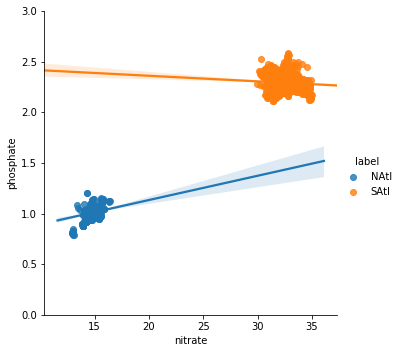

In [69]:
fig = sns.lmplot(x ='nitrate', y= 'phosphate', data = df_SNAtl, hue = 'label')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
plt.ylim([0, 3])

(0, 3)

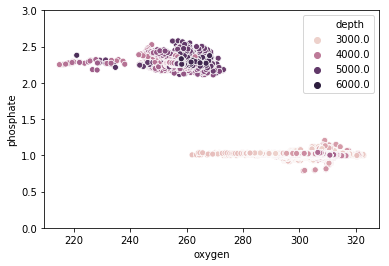

In [91]:
fig = sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_SNAtl, hue = 'depth')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
plt.ylim([0, 3])

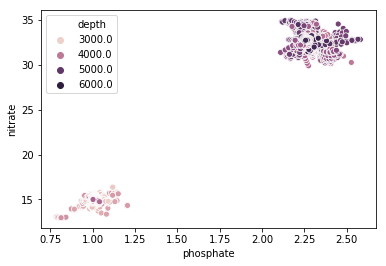

In [68]:
fig = sns.scatterplot(x ='phosphate', y= 'nitrate', data = df_SNAtl, hue = 'depth')
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)


In [8]:
depth_traj['po4_star'][2500].mixing_ratios[0]

array([ 0.92828991,  0.07171009])

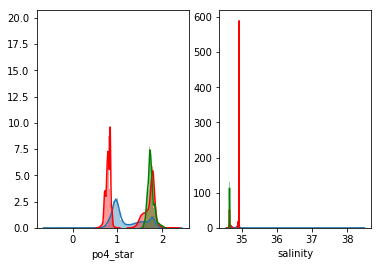

In [176]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
sns.distplot(df_Atl.po4_star, norm_hist = True, ax = ax)
sns.distplot(df_Atl[df_Atl['latitude']> 60].po4_star, norm_hist = False, ax = ax, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']> -70) &(df_Atl['latitude']<-45) &(df_Atl['depth']>3000)].po4_star, norm_hist =True, ax = ax, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']< -70)].po4_star, norm_hist = True, ax = ax, color = 'green')
ax1 = fig.add_subplot(1,2,2)
sns.distplot(df_Atl.salinity, norm_hist = False, ax = ax1)
sns.distplot(df_Atl[df_Atl['latitude']> 60].salinity, norm_hist = False, ax = ax1, color = 'red')
sns.distplot(df_Atl[(df_Atl['latitude']> -70) &(df_Atl['latitude']<-45)].salinity, norm_hist =False, ax = ax1, color = 'red')
sns.distplot(df_Atl[df_Atl['latitude']< -70].salinity, norm_hist = False, ax = ax1, color = 'green')


(34.5, 35.1)

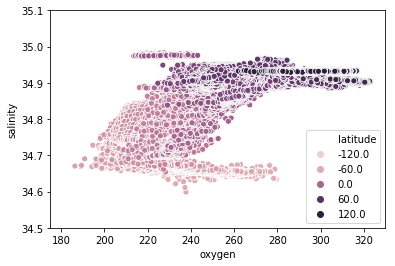

In [178]:
sns.scatterplot(x ='oxygen', y= 'salinity', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.ylim([34.5,35.1])
# plt.xlim([0, 2.5])

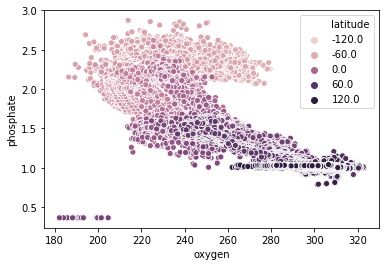

In [180]:
sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))

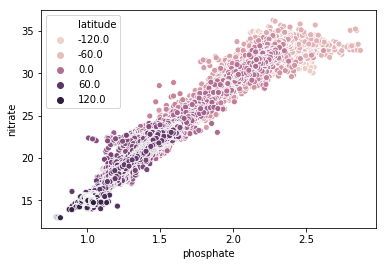

In [38]:
sns.scatterplot(x ='phosphate', y= 'nitrate', data = df_Atl, hue = 'latitude')

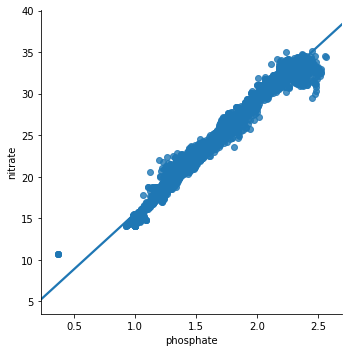

In [88]:
fig = sns.lmplot(x ='phosphate', y= 'nitrate', data = df_Atl)
# sns.lmplot(x ='oxygen', y= 'phosphate', data = df_SAtl, ax = fig)
# plt.ylim([0, 3])

(0.5, 3.5)

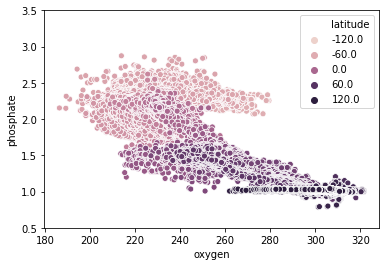

In [66]:
sns.scatterplot(x ='oxygen', y= 'phosphate', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.ylim([0.5,3.5])

(0, 2.5)

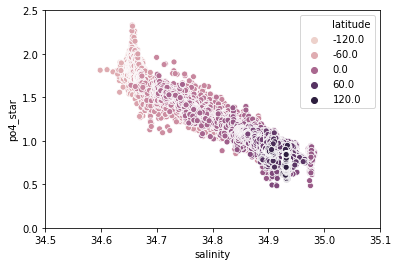

In [37]:
sns.scatterplot(x ='salinity', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.xlim([34.5,35.1])
plt.ylim([0, 2.5])

(0.3, 3)

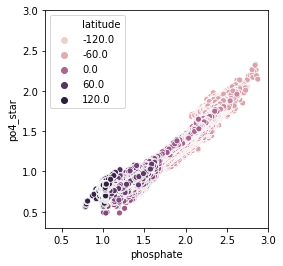

In [81]:
fig = plt.figure(figsize= (4,4))
fig.add_subplot(111)
sns.scatterplot(x ='phosphate', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))
plt.xlim([.3, 3])
plt.ylim([.3, 3])

(34.5, 35.2)

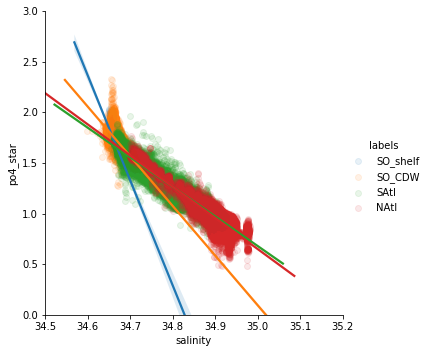

In [83]:
fig = sns.lmplot(x ='salinity', y= 'po4_star', data = df_Atl, hue = 'labels', scatter_kws={'alpha':0.1})
plt.ylim([0, 3])
plt.xlim([34.5, 35.2])

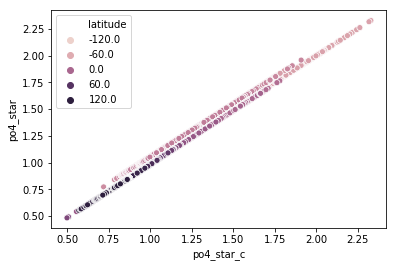

In [42]:
sns.scatterplot(x ='po4_star_c', y= 'po4_star', data = df_Atl, hue = 'latitude', hue_norm=(-90, 90))

(34.5, 35.2)

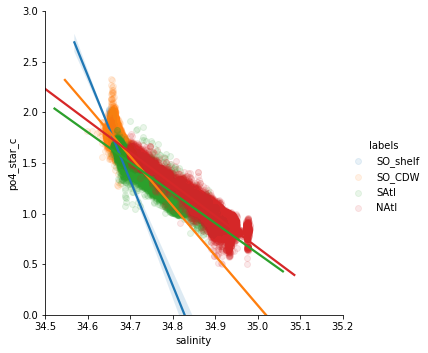

In [43]:
fig = sns.lmplot(x ='salinity', y= 'po4_star_c', data = df_Atl, hue = 'labels', scatter_kws={'alpha':0.1})
plt.ylim([0, 3])
plt.xlim([34.5, 35.2])